In [1]:
import os
import cv2
import torch
import sklearn
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import imblearn as imb
from statistics import mean
from pydicom import dcmread
from sklearn import metrics
import torch.optim as optim
from torchinfo import summary
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from skimage.transform import resize
import torchmetrics.classification as M
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from global_objectives.losses import AUCPRLoss
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.kernel_approximation import PolynomialCountSketch
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler

In [2]:
tqdm.pandas()
%matplotlib inline
torch.multiprocessing.set_start_method('spawn', force=True)

In [3]:
class RSNAScreeningMammographyDataset(Dataset):
    def __init__(self):
        super().__init__()
        f_column_names = ["image_name"]
        f_column_names.extend(["f_" + str(f) for f in range(1, 1001)])
        DATA_HOME = "/scratch/chakraborty.de/python/cs6140-final-project/"
        self.data = pd.read_csv(os.path.join(DATA_HOME, "train.csv"))
        self.features = pd.read_csv(os.path.join(DATA_HOME, "features.csv"), names=f_column_names)
        self.features.image_name = self.features.image_name.str[:-4]
        self.data = self.data.astype({"site_id": "string", 
                                      "patient_id": "string", 
                                      "image_id": "string", 
                                      "laterality": "string", 
                                      "view": "string", 
                                      "cancer": "int64", 
                                      "biopsy": "int64", 
                                      "invasive": "int64", 
                                      "BIRADS": "category", 
                                      "implant": "int64", 
                                      "density": "category", 
                                      "machine_id": "string", 
                                      "difficult_negative_case": "int64"})
        self.data.age = self.normalize(self.data.age.interpolate().to_numpy())
        self.birads = self.data.BIRADS.cat
        self.data.BIRADS = self.birads.codes.astype("int64")
        self.density = self.data.density.cat
        self.data.density = self.density.codes.astype("int64")
        self.data.insert(loc=0, column="image_name", value=(self.data.site_id + "_" + 
                                                            self.data.machine_id + "_" + 
                                                            self.data.patient_id + "_" + 
                                                            self.data.image_id + "_" + 
                                                            self.data.laterality + "_" + 
                                                            self.data.view).to_list())
        self.data.drop(["site_id", "machine_id", "patient_id", "image_id", "laterality", "view"], axis=1, inplace=True)
        self.data = pd.concat([self.features.set_index(keys="image_name", drop=True), 
                               self.data.set_index(keys="image_name", drop=True)], axis=1, join="inner")
        self.X = self.data[np.append(self.features.columns[1:].values.tolist(), ['age', 'implant'])].to_numpy()
#         self.X = self.data[self.features.columns[1:].values.tolist()].to_numpy()
        self.y = self.data.cancer.to_numpy()
        self.class_wt = compute_class_weight(class_weight='balanced', classes=np.unique(self.y), y=self.y)
        print("All data loaded successfully!")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.as_tensor(self.X[idx], dtype=torch.float32).cuda(), torch.as_tensor([self.y[idx]], dtype=torch.float32).cuda()
    
    def normalize(self, img: np.ndarray):
        return np.round(np.divide(np.subtract(img, img.min()), np.ptp(img)), 3)
    
    def normalize_and_resize(self, dicom, new_size=(512, 512)):
        if dicom.PhotometricInterpretation == "MONOCHROME1":
            return self.normalize(resize(np.invert(dicom.pixel_array), new_size))
        return self.normalize(resize(dicom.pixel_array, new_size))
    
    def save_images(self, image_name, out=None):
        image_path = "/scratch/chakraborty.de/python/cs6140-final-project/train_images/" + "/".join(image_name.split("_")[2:4]) + ".dcm"
        return np.multiply(self.normalize_and_resize(dcmread(image_path)), 255).astype(np.uint8)
    
    def load_images(self, image_name, out=None):
        image_path = "/scratch/chakraborty.de/python/cs6140-final-project/data/" + image_name + ".png"
        return np.expand_dims(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), axis=0)
    
    def check_features(self, image_name):
        if not self.features.image_name.str.contains(image_name).any():
            raise KeyError("Feature data not loaded correctly!")

In [4]:
rsna = RSNAScreeningMammographyDataset()

All data loaded successfully!


In [5]:
trn_idx, val_idx = train_test_split(np.arange(len(rsna)), test_size=0.1, stratify=rsna.y)
trn_dataset = Subset(rsna, trn_idx)
val_dataset = Subset(rsna, val_idx)

In [6]:
batch_size = 4096
trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
class SimpleFCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = nn.Sequential(
            nn.Linear(in_features=1000, out_features=100),
            nn.Sigmoid(),
            nn.Linear(in_features=100, out_features=10),
            nn.Sigmoid(),
            nn.Linear(in_features=10, out_features=1),
            nn.Sigmoid()
        )
        self.meta_encoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=2),
            nn.Sigmoid(),
            nn.Linear(in_features=2, out_features=1),
            nn.Sigmoid()
        )
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x1, x2 = x[:, :-2], x[:, -2:]
        x1 = self.image_encoder(x1)
        x2 = self.meta_encoder(x2)
        return self.sigmoid(torch.multiply(x1, x2))

In [127]:
def pfbeta(labels, predictions, beta=rsna.class_wt[1]):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction
    
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result.item()
    else:
        return 0

In [124]:
model = SimpleFCN().cuda()
loss_fn = nn.BCEWithLogitsLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
metric = [M.BinaryAccuracy().cuda(), 
          M.BinaryAUROC().cuda(), 
          M.BinaryPrecision().cuda(), 
          M.BinaryRecall().cuda(), 
          M.BinaryF1Score().cuda(), 
          M.BinaryConfusionMatrix().cuda()]
conf_mat = M.ConfusionMatrix(task='binary', num_classes=2).cuda()

In [10]:
summary(model, input_size=(4096, 1002))

/home/chakraborty.de/.local/lib/python3.8/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/chakraborty.de/.local/lib/python3.8/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
SimpleFCN                                [4096, 1]                 --
├─Sequential: 1-1                        [4096, 1]                 --
│    └─Linear: 2-1                       [4096, 100]               100,100
│    └─Sigmoid: 2-2                      [4096, 100]               --
│    └─Linear: 2-3                       [4096, 10]                1,010
│    └─Sigmoid: 2-4                      [4096, 10]                --
│    └─Linear: 2-5                       [4096, 1]                 11
│    └─Sigmoid: 2-6                      [4096, 1]                 --
├─Sequential: 1-2                        [4096, 1]                 --
│    └─Linear: 2-7                       [4096, 2]                 6
│    └─Sigmoid: 2-8                      [4096, 2]                 --
│    └─Linear: 2-9                       [4096, 1]                 3
│    └─Sigmoid: 2-10                     [4096, 1]                 --
├─Sigmoid

In [11]:
trn_losses = []
val_losses = []
for epoch in tqdm(range(1000)):
    trn_running_loss = 0.0
    trn_size = len(trn_dataloader)
    for X, y in trn_dataloader:
        optimizer.zero_grad()
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()
        trn_running_loss += loss.item()
    trn_losses.append(trn_running_loss / trn_size)
    
    val_running_loss = 0.0
    val_size = len(val_dataloader)
    with torch.no_grad():
        for X, y in val_dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            val_running_loss += loss.item()
    val_losses.append(val_running_loss / val_size)
    
    print(f'epoch: [{epoch + 1:<4}]   training loss: {trn_losses[-1]:.5f}   validation loss: {val_losses[-1]:.5f}')
print('Finished Training')

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: [1   ]   training loss: 0.98742   validation loss: 0.98438
epoch: [2   ]   training loss: 0.98456   validation loss: 0.98275
epoch: [3   ]   training loss: 0.98321   validation loss: 0.98160
epoch: [4   ]   training loss: 0.98215   validation loss: 0.98063
epoch: [5   ]   training loss: 0.98125   validation loss: 0.97980
epoch: [6   ]   training loss: 0.98046   validation loss: 0.97906
epoch: [7   ]   training loss: 0.97975   validation loss: 0.97840
epoch: [8   ]   training loss: 0.97912   validation loss: 0.97781
epoch: [9   ]   training loss: 0.97856   validation loss: 0.97728
epoch: [10  ]   training loss: 0.97804   validation loss: 0.97679
epoch: [11  ]   training loss: 0.97757   validation loss: 0.97633
epoch: [12  ]   training loss: 0.97713   validation loss: 0.97591
epoch: [13  ]   training loss: 0.97672   validation loss: 0.97552
epoch: [14  ]   training loss: 0.97633   validation loss: 0.97515
epoch: [15  ]   training loss: 0.97597   validation loss: 0.97480
epoch: [16

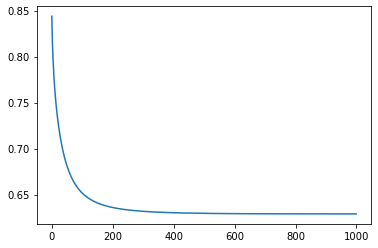

In [37]:
plt.plot(torch.Tensor(val_losses).cpu())
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [29]:
with torch.no_grad():
    print(mean([pfbeta(y, model(X), rsna.class_wt[1]) for X, y in val_dataloader]))

0.4814100116491318


In [15]:
kernel = PolynomialCountSketch(degree=3)
X_train = kernel.fit_transform(rsna.X)

In [16]:
sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=0.0001, class_weight='balanced'))
sgd.fit(X_train, rsna.y)
pfbeta(rsna.y, sgd.predict(X_train), rsna.class_wt[1])

0.5718896322787097

In [17]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, rsna.y)
pfbeta(rsna.y, clf.predict(X_train), rsna.class_wt[1])

0.6265213987636966

In [18]:
rfc = RandomForestClassifier(max_depth=3, class_weight='balanced')
rfc.fit(X_train, rsna.y)
pfbeta(rsna.y, rfc.predict(X_train), rsna.class_wt[1])

0.6260003902043196

In [19]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
cnb = ComplementNB(force_alpha=True)
cnb.fit(X_scaled, rsna.y)
pfbeta(rsna.y, cnb.predict(X_scaled), rsna.class_wt[1])

0.5793741931079853

In [130]:
width = 0.1
row_names = [m.__class__.__name__ for m in metric[:-1]]
clf_metric = [m(torch.as_tensor(rsna.y).cuda(), torch.as_tensor(clf.predict(X_train)).cuda()).item() for m in metric[:-1]]
sgd_metric = [m(torch.as_tensor(rsna.y).cuda(), torch.as_tensor(sgd.predict(X_train)).cuda()).item() for m in metric[:-1]]
rfc_metric = [m(torch.as_tensor(rsna.y).cuda(), torch.as_tensor(rfc.predict(X_train)).cuda()).item() for m in metric[:-1]]
cnb_metric = [m(torch.as_tensor(rsna.y).cuda(), torch.as_tensor(cnb.predict(X_train)).cuda()).item() for m in metric[:-1]]
mlp_metric = [m(torch.as_tensor(rsna.y).cuda(), torch.as_tensor(mlp.predict(X_train)).cuda()).item() for m in metric[:-1]]
row_names.append('ProbabilisticF1')
clf_metric.append(pfbeta(rsna.y, clf.predict(X_train)))
sgd_metric.append(pfbeta(rsna.y, sgd.predict(X_train)))
rfc_metric.append(pfbeta(rsna.y, rfc.predict(X_train)))
cnb_metric.append(pfbeta(rsna.y, cnb.predict(X_train)))
mlp_metric.append(pfbeta(rsna.y, mlp.predict(X_train)))

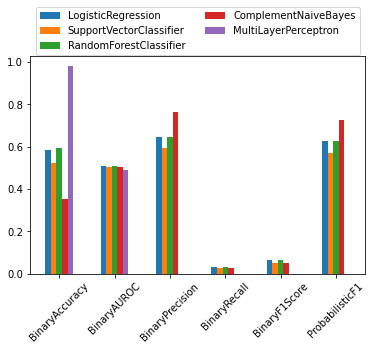

In [144]:
plt.bar(np.arange(len(row_names)) + width*-2, clf_metric, width=width, label='LogisticRegression')
plt.bar(np.arange(len(row_names)) + width*-1, sgd_metric, width=width, label='SupportVectorClassifier')
plt.bar(np.arange(len(row_names)) + width*0, rfc_metric, width=width, label='RandomForestClassifier')
plt.bar(np.arange(len(row_names)) + width*1, cnb_metric, width=width, label='ComplementNaiveBayes')
plt.bar(np.arange(len(row_names)) + width*2, mlp_metric, width=width, label='MultiLayerPerceptron')
plt.xticks(np.arange(len(row_names)), row_names, rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
plt.show()